<a href="https://colab.research.google.com/github/Khadijah-Trawally/QuantumGraphColoring/blob/main/classical_agth_GC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gurobipy  # install gurobipy
!pip install gurobi_optimods  # install gurobipy opts
!pip install cupy-cuda12x

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.9/277.9 kB 1.9 MB/s eta 0:00:00


In [24]:
import random
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


import gurobipy as gp
from gurobi_optimods.qubo import solve_qubo

import time
import os
import pickle
# import cupy as cp

import pandas as pd

from scipy.linalg import eigh


In [3]:
class Graph:
    def __init__(self, vertices):
        """
        Initialize a new graph with a specified number of vertices.

        Args:
            vertices (int): The number of vertices in the graph.
        """
        self.vertices = vertices
        self.graph = {i: [] for i in range(vertices)}
        self.G = nx.Graph()

    def add_edge(self, u, v):
        """
        Add an undirected edge between vertex u and vertex v.

        Args:
            u (int): The starting vertex of the edge.
            v (int): The ending vertex of the edge.
        """
        self.graph[u].append(v)
        self.graph[v].append(u)
        self.G.add_edge(u, v)

    def generate_erdos_renyi(self, p):
        """
        Generate an Erdős–Rényi graph where each edge is added with probability p.

        Args:
            p (float): The probability of adding an edge between any pair of vertices.
        """
        for i in range(self.vertices):
            for j in range(i + 1, self.vertices):
                if random.random() < p:
                    self.add_edge(i, j)

    def add_custom_edges(self, edge_list):
        """
        Add a custom list of edges to the graph.

        Args:
            edge_list (list of tuples): Each tuple represents an edge between two vertices.
        """
        for u, v in edge_list:
            self.add_edge(u, v)

    def get_graph(self, format='networkx'):
        """
        Get the internal representation of the graph based on the desired format.

        Args:
            format (str): The format in which to return the graph.
                          Options are 'networkx', 'dictionary', or 'edges'.
                          'networkx' returns the NetworkX graph.
                          'dict' returns the internal adjacency list representation.
                          'edges' returns a list of edges.

        Returns:
            Depending on the format:
            - networkx.Graph: The graph in NetworkX format for hybrid .
            - dict: The adjacency list representation of the graph for dsatur .
            - list: A list of edges in the graph for qubo.
        """
        if format == 'networkx':
            return self.G
        elif format == 'dict':
            return self.graph, self.G
        elif format == 'edges':
            return [(u, v) for u in range(self.vertices) for v in self.graph[u] if u < v]
        else:
            raise ValueError("Invalid format. Choose 'networkx', 'dictionary', or 'edges'.")





class GraphVisualizer:
    @staticmethod
    def color_graph_dsatur(G, colors, layout='spring', filename='graph_plot.png'):
        """
        Visualize the graph with a given coloring using the dsatur algorithm.

        Args:
            G (networkx.Graph): The graph to visualize.
            colors (dict): A dictionary where the key is the node and the value is the assigned color.
            layout (str, optional): The layout of the graph ('spring', 'circular', or 'random'). Defaults to 'spring'.
            filename (str, optional): The filename to save the plot. Defaults to 'graph_plot.png'.
        """
        color_map = [colors[node] for node in G.nodes()]

        if (layout == 'spring'):
            pos = nx.spring_layout(G)
        elif (layout == 'circular'):
            pos = nx.circular_layout(G)
        else:
            pos = nx.random_layout(G)

        nx.draw(G, pos, node_color=color_map, with_labels=True, cmap=plt.cm.Set3, node_size=700)

        plt.savefig(filename)
        plt.show()
        plt.clf()  # Clear the plot to prevent overlap in subsequent plots

    @staticmethod
    def color_graph_qubo(n, c, edges, solution, layout='spring', filename=None):
        """
        Visualize a coloring solution for a graph using a QUBO (Quadratic Unconstrained Binary Optimization) approach.

        Args:
            n (int): Number of nodes in the graph.
            c (int): Number of colors available.
            edges (list of tuples): List of edges in the graph.
            solution (list or numpy.array): The solution vector from the solver, a flat list or numpy array of size n*c.
            layout (str, optional): Layout of the graph ('spring' or 'circular'). Defaults to 'spring'.
            filename (str, optional): If provided, saves the plot to the specified filename. Defaults to None.
        """
        # Create a graph
        G = nx.Graph()
        G.add_nodes_from(range(n))  # Nodes range from 0 to n-1
        G.add_edges_from(edges)

        # Assign colors to nodes based on the solution
        color_map = []
        for i in range(n):
            node_colors = solution[i * c:(i + 1) * c]

            # Get the index of the color assigned to this node (index of '1' in the slice)
            if np.sum(node_colors) == 1:
                node_color = np.where(node_colors == 1)[0][0]
            else:
                node_color = -1  # If no valid color, or multiple colors assigned, use -1

            color_map.append(node_color)

        # Define color options
        #color_options = plt.cm.get_cmap('Set3', c)
        color_options = plt.cm.Set3

        # Handle nodes with no valid color
        node_colors_visual = []
        for col in color_map:
            if col == -1:
                node_colors_visual.append('gray')  # Color unassigned nodes as gray
            else:
                node_colors_visual.append(color_options(col))

        # Visualize the graph
        pos = nx.spring_layout(G) if layout == 'spring' else nx.circular_layout(G)  # Positions for all nodes
        nx.draw(G, pos, with_labels=True, node_color=node_colors_visual, node_size=700)

        # Show the plot or save to file
        if filename:
            plt.savefig(filename)
        plt.show()



    @staticmethod
    def plot_bar_chart(coordination_numbers, chromatic_numbers, std_chromatic_num, size, filename='bar_chart.png', x_min=None, x_max=None, bar_width=8, log_scale = False):
        """
        Plot a bar chart showing the chromatic number vs coordination number for a fixed graph size.
        """
        plt.figure(figsize=(8, 6))

        # # Add padding to x-axis
        # x_padding = (x_max - x_min) * 0.2  # Add 20% padding
        # x_min -= x_padding
        # x_max += x_padding

        # Generate x positions
        x_positions = np.linspace(x_min, x_max, len(coordination_numbers))

        # Plot the bar chart
        plt.bar(
            x_positions,
            chromatic_numbers,
            yerr=std_chromatic_num,
            width=bar_width,
            color='grey',
            alpha=0.7,
        )

        plt.xlabel('Average Coordination Number (Degree)')
        plt.ylabel('Average Chromatic Number')
        plt.title(f'Chromatic Number vs Coordination Number (Graph Size: {size})')

        # Set custom x-ticks
        plt.xticks(rotation=45)

        if log_scale:
            plt.yscale('log')

        plt.tight_layout()
        plt.savefig(filename)
        plt.show()

    @staticmethod
    def plot_separate_bar_charts(results, log_scale = False):
        """
        Plot separate bar charts for each graph size using the average coordination and chromatic numbers.

        Args:
            results (dict): Dictionary where each key is a graph size, and each value is a dictionary mapping
                            avg coordination numbers to avg chromatic numbers.
        """
        # Determine global x-axis range across all sizes
        all_coordination_numbers = [key for data in results.values() for key in data.keys()]
        x_min = min(all_coordination_numbers)
        x_max = max(all_coordination_numbers)

        for size, data in results.items():
            # Extract data for this size
            mean_coordination_numbers = list(data.keys())
            mean_chromatic_num = [v[0] for v in data.values()]
            std_chromatic_num = [v[1] for v in data.values()]

            # Create a filename for each plot
            filename = f"chromatic_vs_coordination_size_{size}.png"

            # Plot chart for the current size
            GraphVisualizer.plot_bar_chart(
                mean_coordination_numbers,
                mean_chromatic_num,
                std_chromatic_num,
                size,
                filename,
                x_min=x_min,
                x_max=x_max,
                bar_width=(x_max - x_min) / len(mean_coordination_numbers) * 0.5,
                log_scale = log_scale
            )


# Graph coloring with Dsatur

In [4]:
class DSatur:
    """
    Implements the DSatur algorithm for graph coloring, where the goal is to assign colors
    to the vertices such that no two adjacent vertices have the same color.

    Args:
        graph (tuple): A tuple containing two elements:
                       - dict: Adjacency list representation of the graph.
                       - networkx.Graph: The NetworkX graph object.
    """
    def __init__(self, graph):
        """
        Initialize the DSatur algorithm with the graph structure.

        Args:
            graph (tuple): A tuple containing the adjacency list (dict) and the NetworkX graph object.
        """
        self.graph, self.G = graph  # Adjacency list and the NetworkX graph object
        self.vertices = len(self.graph)  # Number of vertices in the graph
        self.colors = {}  # Stores the color assigned to each vertex
        self.saturation_degrees = {u: 0 for u in range(self.vertices)}  # Stores saturation degree of each vertex
        self.degrees = {u: len(self.graph[u]) for u in range(self.vertices)}  # Stores degree of each vertex

    def select_vertex(self):
        """
        Select the next vertex to color based on the DSatur heuristic.
        The vertex with the highest saturation degree (most adjacent differently colored vertices) is selected.
        If multiple vertices have the same saturation degree, the vertex with the highest degree is chosen.

        Returns:
            int: The selected vertex for coloring.
        """
        max_degree = -1  # Track the maximum vertex degree
        max_saturation = -1  # Track the maximum saturation degree
        selected_vertex = None  # Placeholder for the selected vertex

        # Iterate over all vertices
        for v in range(self.vertices):
            if v not in self.colors:  # Only consider uncolored vertices
                # Select vertex based on saturation and degree
                if (self.saturation_degrees[v] > max_saturation or
                    (self.saturation_degrees[v] == max_saturation and self.degrees[v] > max_degree)):
                    max_saturation = self.saturation_degrees[v]
                    max_degree = self.degrees[v]
                    selected_vertex = v  # Update selected vertex

        return selected_vertex  # Return the vertex selected for coloring

    def find_color(self, v):
        """
        Find the smallest available color for the given vertex, ensuring no adjacent vertex has the same color.

        Args:
            v (int): The vertex for which to find an available color.

        Returns:
            int: The smallest available color for the vertex.
        """
        # Get the colors of adjacent vertices
        adjacent_colors = {self.colors[neighbor] for neighbor in self.graph[v] if neighbor in self.colors}

        color = 0  # Start with the smallest color (0)
        # Keep incrementing the color until it's not used by any adjacent vertex
        while color in adjacent_colors:
            color += 1

        return color

    def color_graph(self):
        """
        Color the entire graph using the DSatur algorithm. It ensures that no two adjacent vertices have the same color.

        Returns:
            dict: A dictionary where the keys are vertices and the values are the assigned colors.
        """
        # Continue coloring vertices until all are colored
        while len(self.colors) < self.vertices:
            vertex = self.select_vertex()  # Select the next vertex to color
            color = self.find_color(vertex)  # Find the smallest available color for the selected vertex
            self.colors[vertex] = color  # Assign the color to the vertex

            # Update the saturation degrees of the neighbors
            for neighbor in self.graph[vertex]:
                if neighbor in self.colors:  # Check only colored neighbors
                    assert self.colors[vertex] != self.colors[neighbor], \
                        f"Invalid coloring: Vertex {vertex} and {neighbor} have the same color {self.colors[vertex]}."

            # Assert no two adjacent vertices share the same color
            for neighbor in self.graph[vertex]:
                if neighbor not in self.colors:

                    self.saturation_degrees[neighbor] += 1  # Increase saturation degree if a new color is used
        # assert self.is_valid_coloring(), "Graph coloring failed validation."
        # print(f"Graph successfully colored with {len(set(self.colors.values()))} colors.")
        return self.colors  # Return the dictionary of vertex colors



    def is_valid_coloring(self):
        """
        Validates the coloring of the graph by ensuring no two adjacent vertices share the same color.

        Returns:
            bool: True if the coloring is valid, False otherwise.
        """
        for vertex, neighbors in self.graph.items():
            vertex_color = self.colors.get(vertex, None)
            for neighbor in neighbors:
                if self.colors.get(neighbor, None) == vertex_color:
                    return False  # Found a conflict
        return True  # All vertices have valid coloring

    def get_minimum_colors(self):
        """
        Get the minimum number of distinct colors used to color the graph.

        Returns:
            int: The number of distinct colors used.
        """
        return len(set(self.colors.values()))  # Return the number of unique colors used in the graph


True


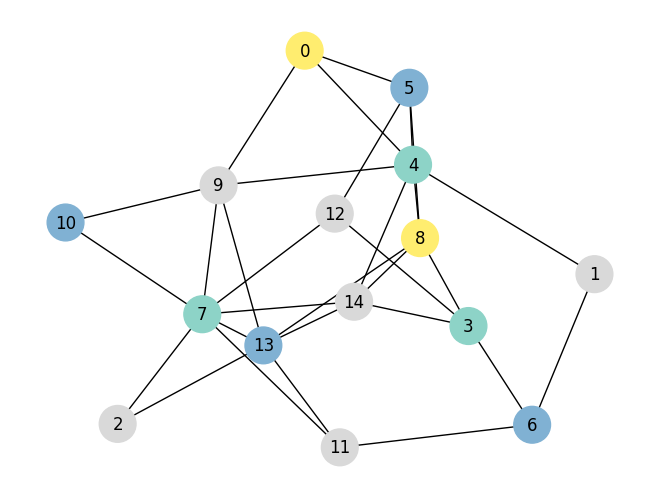

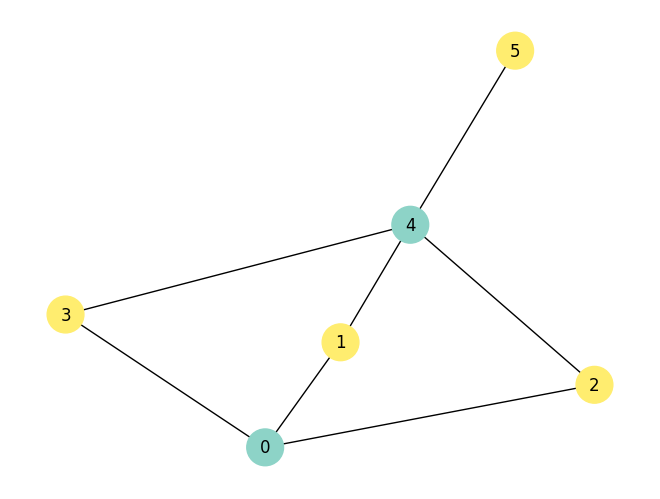

<Figure size 640x480 with 0 Axes>

In [5]:

# Example usage:

# 1. Generate an Erdős–Rényi graph
g1 = Graph(15)  # 10 vertices
g1.generate_erdos_renyi(p=0.3)
graph_data = g1.get_graph(format = 'dict')


dsatur1 = DSatur(graph_data)
erdos_colors = dsatur1.color_graph()
print(dsatur1.is_valid_coloring())



# # Validate the coloring
# if dsatur1.is_valid_coloring():
#     print("Valid coloring:", erdos_colors)
# else:
#     print("Invalid coloring:", erdos_colors)

GraphVisualizer.color_graph_dsatur(graph_data[1], erdos_colors, layout='spring', filename='erdos_renyi_graph.png')

# 2. Use a custom edge list
custom_edges = [(0, 1), (0, 2), (0, 3), (1, 4), (2, 4), (3, 4), (4, 5)]
g2 = Graph(6)  # 6 vertices
g2.add_custom_edges(custom_edges)
graph_data_custom = g2.get_graph(format = 'dict')

dsatur2 = DSatur(graph_data_custom)
custom_colors = dsatur2.color_graph()

GraphVisualizer.color_graph_dsatur(graph_data_custom[1], custom_colors, layout='spring', filename='custom_graph.png')




In [6]:
def test_dsatur_on_random_graphs(sizes, probabilities, num_runs=20):
    """
    Test the DSatur graph coloring algorithm on Erdős–Rényi random graphs of different sizes and edge probabilities.

    Args:
        sizes (list of int): A list of sizes, where each size represents the number of vertices in the graph.
        probabilities (list of float): A list of probabilities, where each probability represents the likelihood
                                       of an edge existing between any pair of vertices.
        num_runs (int): Number of runs to average over for each size and probability.

    Returns:
        dict: A dictionary where each key is a graph size, and each value is a dictionary.
              Each inner dictionary maps average coordination numbers to average chromatic numbers.
    """
    results = {}

    # Iterate over each graph size
    for size in sizes:
        results[size] = {}

        # Iterate over each probability
        for p in probabilities:
            coordination_numbers = []
            chromatic_numbers = []


            # Run multiple instances for each probability
            for _ in (range(num_runs)):
                g = nx.erdos_renyi_graph(size, p)

                if g.number_of_edges() == 0:
                    # Skip if the graph has no edges (trivial graph)
                    continue

                # Calculate the average degree (coordination number) of the graph
                degrees = [deg for _, deg in g.degree()]
                avg_degree = np.mean(degrees)
                coordination_numbers.append(avg_degree)


                # Prepare the graph data for DSatur
                graph_data = (dict(g.adjacency()), g)
                dsatur = DSatur(graph_data)

                # Run the DSatur coloring algorithm
                dsatur.color_graph()

                # Validate the coloring
                if dsatur.is_valid_coloring():
                    # Get the minimum number of colors used
                    min_colors = dsatur.get_minimum_colors()
                    chromatic_numbers.append(min_colors)
                else:
                    print(f"Invalid coloring detected on graph with size={size}, p={p}")
                    break

            # Only compute averages if valid data exists
            #if coordination_numbers and chromatic_numbers:
            avg_coordination_number = round(np.mean(coordination_numbers), 2)
            avg_chromatic_number = round(np.mean(chromatic_numbers), 2)
            std_chromatic_number = round(np.std(chromatic_numbers), 2)
            results[size][avg_coordination_number] = [avg_chromatic_number,std_chromatic_number]

    return results


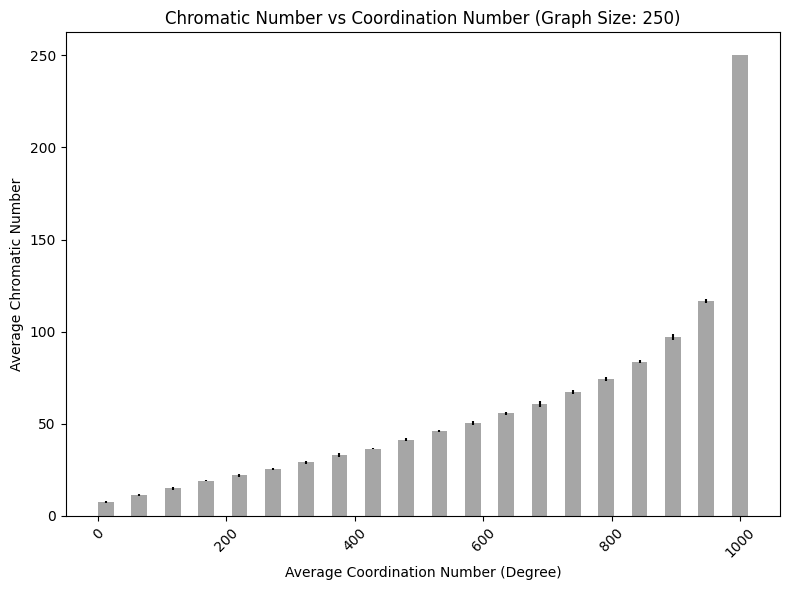

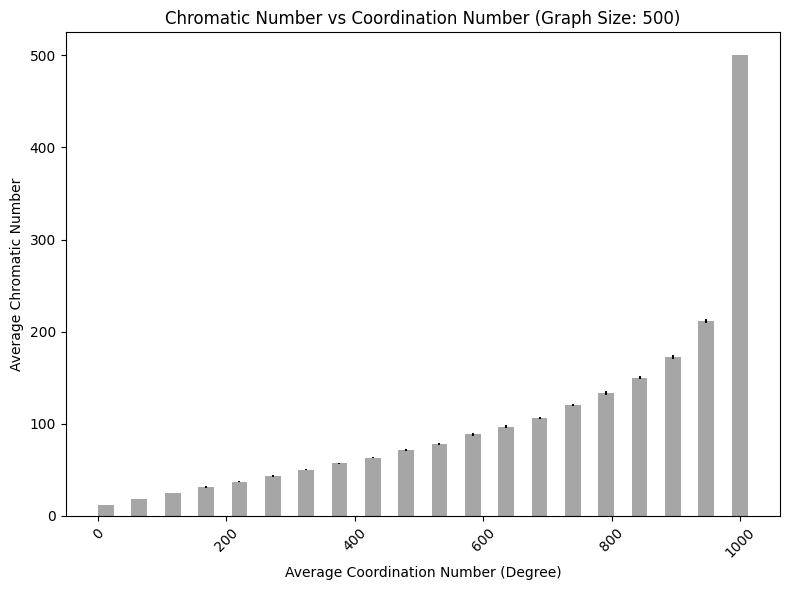

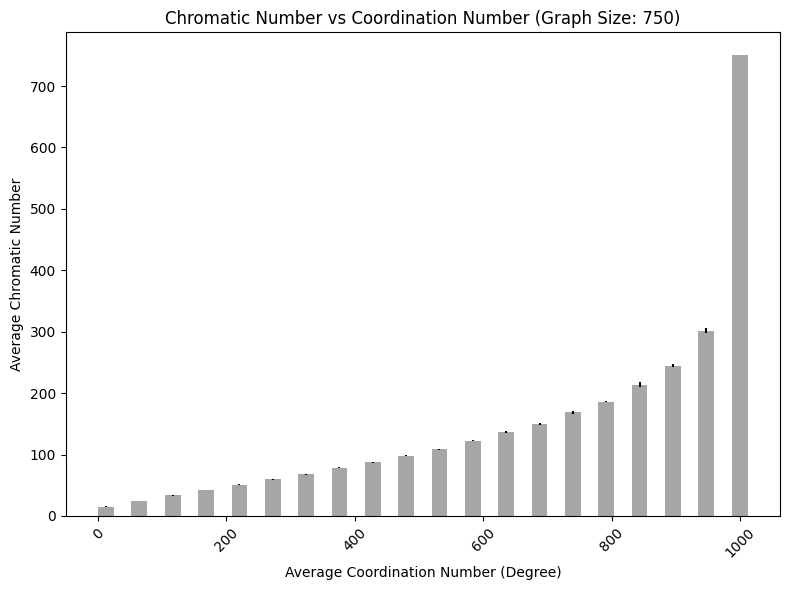

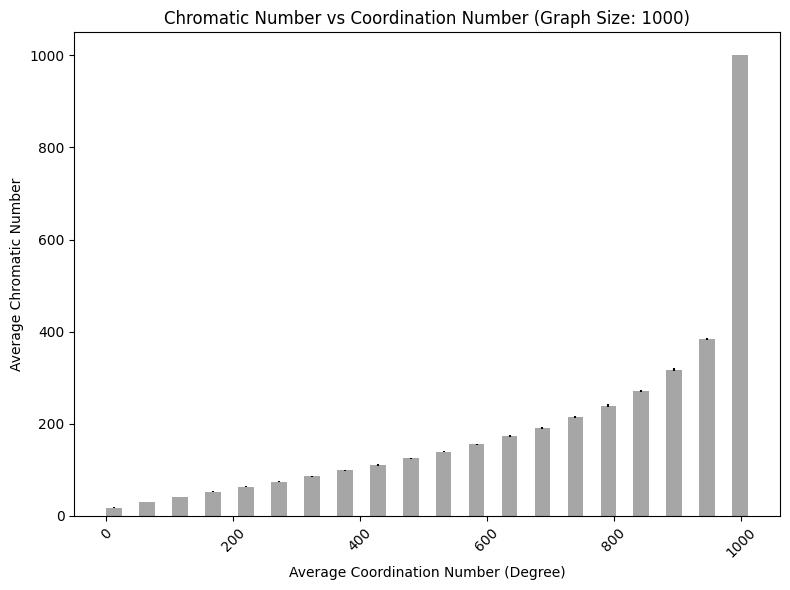

In [7]:
sizes = [250,500, 750, 1000]  # Different graph sizes
probabilities = [round(p, 2) for p in np.arange(0.05, 1.05, 0.05)]  # Edge probabilities from 0.1 to 1.0 in s teps of 0.05

results= test_dsatur_on_random_graphs(sizes, probabilities, num_runs = 5)

#print(results)

GraphVisualizer.plot_separate_bar_charts(results, log_scale = False)

#QUBO implementation with Gurobi

# QUBO Formulation for Quantum Graph Coloring

The formulation of QUBO for the graph coloring problem involves minimizing an objective function $ f(\mathbf{x}) $ subject to certain constraints. The cost function is defined as follows:

\begin{equation}
    \text{minimize } f(\mathbf{x}) = \mathbf{x}^T Q \mathbf{x}
\end{equation}

where $ {x} $ is a vector of binary variables, and  ${Q}$  is a symmetric matrix.

For chromatic number minimization, the objective function $f({x}) $ is defined as:

\begin{equation}
    f(\mathbf{y}) = \sum_{k=1}^{c}  y_{k}
\end{equation}

In the graph coloring problem, a valid coloring is represented by a set of binary variables $ y_{k} $ taking values in $\{0, 1\}$, defined as:

\begin{equation}
    y_{k}=
\begin{cases}
    1 & \text{if color } k \text{ is assigned } \\
    0 & \text{otherwise}.
\end{cases}
\end{equation}


Here, $ i \in \{1, 2, ..., n\}$ represents the nodes in the graph, and $k \in \{1, 2, ..., c\}$ represents the available colors, where \( n \) is the number of nodes and \( c \) is the number of colors.



### 1. Constraints on the  cost function  

\begin{equation}
    y_{k} - x_{ik}  \geq 0
\end{equation}


We introduce a penalty term $P_1({x})$ that penalizes the violation of this constraint.


\begin{equation}
    P_1(\mathbf{x}) = \sum_{i=1}^{n} \sum_{k=1}^{c}  \left(x_{ik} - x_{ik}y_{k}\right)
\end{equation}

### 2. All Nodes Must Be Colored

\begin{equation}
    \sum_{k=1}^{c} x_{ik} = 1
\end{equation}

We introduce a penalty term $P_2({x})$ that penalizes the violation of this constraint.

\begin{equation}
    P_2(\mathbf{x}) = \sum_{i=1}^{n} \left(1 - \sum_{k=1}^{c} x_{ik}\right)^2
\end{equation}

### 3. Adjacent Nodes Must Have Different Colors

\begin{equation}
    x_{ik} + x_{jk} \leq 1
\end{equation}

The penalty term $P_3(\mathbf{x})$ is introduced to enforce this constraint,

\begin{equation}
    P_3(\mathbf{x}) = \sum_{(i,j) \in E} \sum_{k=1}^{c} x_{ik}x_{jk}
\end{equation}



### Problem Hamiltonian

The problem Hamiltonian $ H_p$ derived from the QUBO formulation as given below:

\begin{equation}
H_p(\mathbf{x}) =  \lambda_1 P_1(\mathbf{x}) + \lambda_2 P_2(\mathbf{x}) + \lambda_3 P_3(\mathbf{x})
\end{equation}

where $\lambda_1$ , $\lambda_2$ and $\lambda_3 $ are penalty constants.


Given that $x_{ik}$ is a binary variable in ${0,1}$, this implies $x_{ik}$= $x_{ik}^2$ \.

### Expanding $P_{2}(x)$

\begin{align}
P_2(\mathbf{x}) &= \sum_{i=1}^{n} \left(1 - \sum_{k=1}^{c} x_{ik}\right)^2 \\
&= \sum_{i=1}^{n} \left(1 - 2\sum_{k=1}^{c} x_{ik} + \left(\sum_{k=1}^{c} x_{ik}\right)^2\right) \\
&= \sum_{i=1}^{n} \left(1 - \sum_{k=1}^{c} x_{ik} + 2\sum_{k=1}^{c-1}\sum_{k'=k+1}^{c} x_{ik}x_{ik'}\right)
\end{align}

 Hence:

\begin{equation}
H_p(\mathbf{x}) = \lambda_1\sum_{i=1}^{n} \sum_{k=1}^{c}\left(x_{ik} - x_{ik}y_{k}\right) + \lambda_2\sum_{i=1}^{n} \left(1 - \sum_{k=1}^{c} x_{ik} + 2\sum_{k=1}^{c-1}\sum_{k'=k+1}^{c} x_{ik}x_{ik'}\right) + \lambda_3\sum_{(i,j) \in E} \sum_{k=1}^{c} x_{ik} x_{jk}
\end{equation}



    


In [8]:

class QUBOMatrix:
    def __init__(self, n, c, edges, lambda1=1.0, lambda2=10.0, lambda3=10.0):
        """
        Initialize the QUBOMatrix class with problem parameters.
        :param n: Number of nodes
        :param c: Number of colors
        :param edges: List of edges in the graph, where each edge is a tuple (i, j)
        :param lambda1: Penalty for cost function constraints (default: 1.0)
        :param lambda2: Penalty for coloring constraints (default: 10.0)
        :param lambda3: Penalty for adjacency constraints (default: 10.0)
        """
        self.n = n
        self.c = c
        self.edges = edges
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.lambda3 = lambda3
        self.Q = self.generate_qubo_matrix()

    def generate_qubo_matrix(self):
        """
        Create the symmetric Q matrix for the QUBO formulation of the graph coloring problem.
        :return: Q matrix
        """
        # Initialize the Q matrix
        Q = np.zeros((self.n * self.c + self.c, self.n * self.c + self.c))

        # Minimize chromatic number: Add diagonal entries for y_k
        for k in range(self.c):
            idx_yk = self.n * self.c + k
            Q[idx_yk, idx_yk] += 1.0  # Coefficient to minimize y_k

        # Constraint 1: Ensure y_k >= x_ik
        for i in range(self.n):
            for k in range(self.c):
                idx = i * self.c + k
                idx_yk = self.n * self.c + k
                Q[idx, idx] += self.lambda1  # x_ik^2 term
                Q[idx, idx_yk] -= self.lambda1  # x_ik * y_k cross term
                Q[idx_yk, idx] -= self.lambda1  # Symmetry for cross term

        # Constraint 2: Each node must have exactly one color
        for i in range(self.n):
            for k in range(self.c):
                idx = i * self.c + k
                Q[idx, idx] -= self.lambda2  # Penalty for x_ik
                for k_prime in range(k + 1, self.c):
                    idx_prime = i * self.c + k_prime
                    Q[idx, idx_prime] += self.lambda2  # Cross penalty
                    Q[idx_prime, idx] += self.lambda2  # Symmetry for cross term

        # Constraint 3: Adjacent nodes must have different colors
        for (i, j) in self.edges:
            for k in range(self.c):
                idx_i = i * self.c + k
                idx_j = j * self.c + k
                Q[idx_i, idx_j] += self.lambda3  # Penalty for adjacent nodes
                Q[idx_j, idx_i] += self.lambda3  # Symmetry for cross term

        return Q




class QUBOValidator:
    def __init__(self, n, c, edges, solution):
        """
        Initialize the QUBOValidator class with the solution and graph parameters.
        :param n: Number of nodes
        :param c: Number of colors
        :param edges: List of edges in the graph
        :param solution: Solution vector (binary variables x and y from solver)
        """
        self.n = n
        self.c = c
        self.edges = edges
        self.solution = solution
        self.x = solution[:n * c]  # Extract x_ik variables
        self.y = solution[n * c:]  # Extract y_k variables

    def validate_constraints(self):
        """
        Validate the constraints of the QUBO solution.
        :return: True if all constraints are satisfied, otherwise False
        """
        # Check Constraint 1: y_k >= x_ik
        for i in range(self.n):
            for k in range(self.c):
                idx = i * self.c + k
                if self.x[idx] == 1 and self.y[k] == 0:
                    print(f"Constraint 1 violated: y[{k}] < x[{i},{k}]")
                    return False

        # Check Constraint 2: Each node must have exactly one color
        for i in range(self.n):
            color_sum = sum(self.x[i * self.c + k] for k in range(self.c))
            if color_sum != 1:
                print(f"Constraint 2 violated: Node {i} has {color_sum} colors assigned.")
                return False

        # Check Constraint 3: Adjacent nodes must have different colors
        for (i, j) in self.edges:
            for k in range(self.c):
                idx_i = i * self.c + k
                idx_j = j * self.c + k
                if self.x[idx_i] == 1 and self.x[idx_j] == 1:
                    print(f"Constraint 3 violated: Nodes {i} and {j} share color {k}.")
                    return False

        print("All constraints satisfied.")
        return True

    def compute_chromatic_number(self):
        """
        Compute the chromatic number from the solution.
        :return: Chromatic number if all constraints are satisfied, otherwise None
        """
        if not self.validate_constraints():
            print("Chromatic number cannot be computed because constraints are not satisfied.")
            return None

        # Compute the chromatic number if constraints are satisfied
        chromatic_number = sum(self.y)
        #print(f"Chromatic Number: {chromatic_number}")
        return chromatic_number


The QUBO matrix is symmetric.
New QUBO solution found with objective 0.0


INFO:gurobi_optimods.qubo:New QUBO solution found with objective 0.0


New QUBO solution found with objective -9.0


INFO:gurobi_optimods.qubo:New QUBO solution found with objective -9.0


[0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1.]
All constraints satisfied.
The chromatic number of the graph is: 3.0


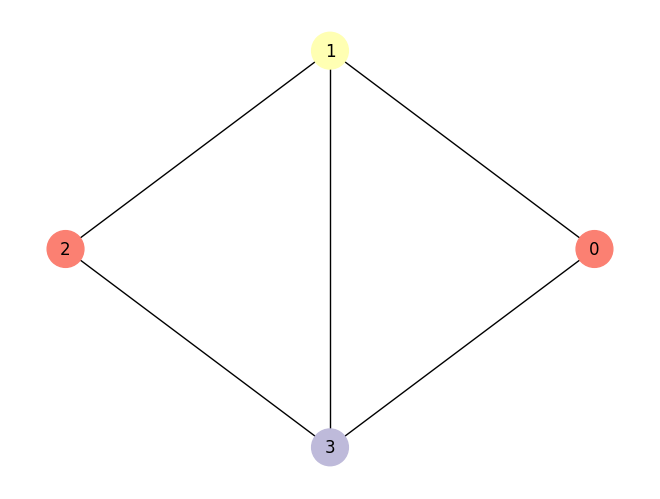

In [9]:



# Example usage
lambda1 = 1
lambda2 = 2
lambda3 = 2

# n = 6
# c = 6
# edges = [(0, 1), (0, 2), (0, 3), (1, 4), (2, 4), (3, 4), (4, 5)]
n = 4  # Number of nodes
c = 4  # Number of colors
edges = [(0, 1), (1, 2), (2, 3), (3, 0), (1, 3)]  # List of edge

# Initialize the QUBO problem
qubo_problem = QUBOMatrix(n, c, edges, lambda1, lambda2, lambda3)

# Symmetry check
if np.allclose(qubo_problem.Q, qubo_problem.Q):
  print("The QUBO matrix is symmetric.")
else:
  print("The QUBO matrix is not symmetric!")
#Q = qubo_problem.generate_qubo_matrix_qubo_matrix()

result = solve_qubo(qubo_problem.Q)
res = result.solution
print(res)

validator = QUBOValidator(n, c, edges, res)

# Compute chromatic number
chromatic_number = validator.compute_chromatic_number()
if chromatic_number is not None:
    print(f"The chromatic number of the graph is: {chromatic_number}")
else:
    print("Unable to compute chromatic number due to constraint violations.")



# Visualize the solution using the GraphVisualizer directly
GraphVisualizer.color_graph_qubo(n, c, edges, res, 'simple_graph_qubo')


In [25]:
def load_graph(file_path):
        """
        Loads a stored graph instance from a pickle file and updates the instance attributes.

        Parameters:
        file_path (str): Path to the pickle file.

        Returns:
        dict: A dictionary containing 'n', 'c', and 'edges'.
        """
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"The file {file_path} does not exist.")

        with open(file_path, "rb") as f:
            try:
                graph_data = pickle.load(f)
            except pickle.UnpicklingError:
                raise ValueError(f"The file {file_path} is not a valid pickle file.")

        # Validate loaded data
        if not isinstance(graph_data, dict) or "n" not in graph_data or "c" not in graph_data or "edges" not in graph_data:
            raise ValueError(f"The file {file_path} does not contain valid graph data.")

        # Update instance attributes
        n = graph_data["n"]
        c = graph_data["c"]
        edges = graph_data["edges"]

        return graph_data


file_path = '/content/n_16_c_8_0.pkl'  # Example path
# Load the graph instance
graph_data = load_graph(file_path)

print(graph_data)

{'n': 16, 'c': 8, 'edges': [(0, 1), (0, 2), (0, 3), (0, 5), (0, 9), (0, 11), (0, 12), (1, 4), (1, 5), (1, 6), (1, 7), (1, 9), (1, 11), (1, 12), (1, 14), (2, 3), (2, 8), (2, 10), (2, 14), (3, 4), (3, 5), (3, 8), (3, 9), (3, 11), (3, 13), (3, 14), (4, 6), (4, 8), (4, 11), (4, 13), (4, 14), (4, 15), (5, 8), (5, 11), (5, 12), (5, 14), (5, 15), (6, 8), (6, 11), (6, 14), (6, 15), (7, 12), (7, 13), (7, 14), (8, 9), (8, 10), (8, 12), (9, 10), (9, 13), (9, 14), (10, 11), (10, 14), (10, 15), (11, 12), (11, 13), (11, 15), (12, 14), (12, 15), (13, 14)]}


New QUBO solution found with objective 0.0


INFO:gurobi_optimods.qubo:New QUBO solution found with objective 0.0


New QUBO solution found with objective -28.200000000000003


INFO:gurobi_optimods.qubo:New QUBO solution found with objective -28.200000000000003


New QUBO solution found with objective -29.199999999999996


INFO:gurobi_optimods.qubo:New QUBO solution found with objective -29.199999999999996


New QUBO solution found with objective -29.200000000000003


INFO:gurobi_optimods.qubo:New QUBO solution found with objective -29.200000000000003


New QUBO solution found with objective -29.200000000000003


INFO:gurobi_optimods.qubo:New QUBO solution found with objective -29.200000000000003


New QUBO solution found with objective -29.2


INFO:gurobi_optimods.qubo:New QUBO solution found with objective -29.2


New QUBO solution found with objective -28.200000000000003


INFO:gurobi_optimods.qubo:New QUBO solution found with objective -28.200000000000003


New QUBO solution found with objective -30.200000000000003


INFO:gurobi_optimods.qubo:New QUBO solution found with objective -30.200000000000003


136
All constraints satisfied.
The chromatic number of the graph is: 5.0


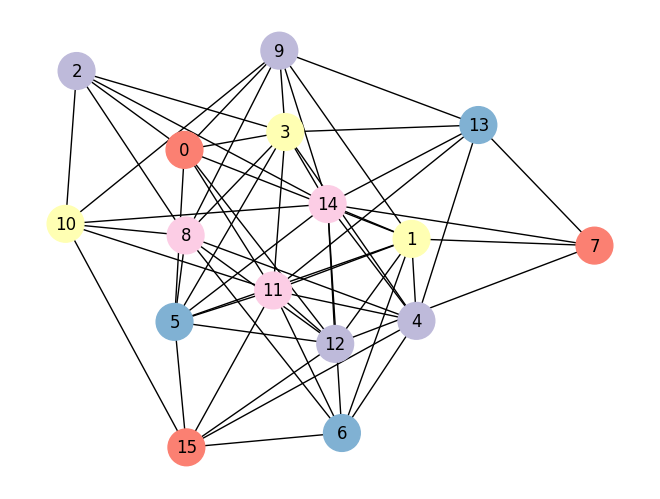

In [27]:
# 1. Generate an Erdős–Rényi graph
# Example usage


# g1 = Graph(n)  # 10 vertices
# g1.generate_erdos_renyi(p=0.5)
# graph_data = g1.get_graph(format = 'edges')
file_path = '/content/n_16_c_8_0.pkl'  # Example path
# Load the graph instance
graph_data = load_graph(file_path)
n = graph_data['n']
c = graph_data['c']
edges = graph_data['edges']
qubo_problem1 = QUBOMatrix(n, c, edges, lambda1 = 1.1, lambda2 = 1.1, lambda3 = 1.1)

#Q = qubo_problem.create_qubo_matrix()

result1 = solve_qubo(qubo_problem1.Q)
res1 = result1.solution

print(len(res1))

validator = QUBOValidator(n, c, edges, res1)

# Compute chromatic number
chromatic_number = validator.compute_chromatic_number()
if chromatic_number is not None:
    print(f"The chromatic number of the graph is: {chromatic_number}")
else:
    print("Unable to compute chromatic number due to constraint violations.")



GraphVisualizer.color_graph_qubo(n , c, edges, res1, layout='spring', filename='erdos_renyi_graph_qubo.png')

# Optional Part

### This part can only be use with Gurobi licenses due to high parameters  